In [ ]:
# Carga de paquetes 
import os 
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
os.chdir("/content/drive/My Drive/Colab Notebooks/proyecto")

import matplotlib.pyplot as plt
import numpy  as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as sfm

from io import StringIO
from matplotlib.widgets import Slider, Button, RadioButtons
from scipy import interp
from scipy.optimize import fsolve
from scipy.stats import chi2_contingency, ttest_ind
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import export_graphviz
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from statsmodels.formula.api import ols


from IPython.display import display_html

Mounted at /content/drive


In [ ]:
#Cargar la informacion
df = pd.read_csv('data.csv')
df.shape

(11333, 19)

In [ ]:
df.head(10)

,id,status,payment_choice,tax_amount,subtotal_amount,delivery_amount,total_amount,is_takeout,created_at,estimated_delivery_at,delivery_address,is_scheduled,people,payment_status,tip_amount,donation_amount,in_the_restaurant,birth_date,gender
0,5916,Por entregar,Efectivo o datáfono,20600,278100,15000,293100,False,2020-04-03 17:11:33.975146+00,2020-04-03 21:24:45.234106+00,Kra 19a No. 107-55,False,4,Pendiente,0,0,False,1984-04-03,Femenino
1,2375,Entregado,Efectivo o datáfono,3837,51800,5000,56800,False,2019-08-12 01:13:42.783548+00,2019-08-12 01:55:29.911761+00,Cll 87 No. 19c-41,False,2,Pendiente,0,0,False,1969-09-10,Femenino
2,6338,Por entregar,Efectivo o datáfono,14177,191400,10000,201400,False,2020-04-12 15:31:50.36001+00,2020-04-12 18:49:46.898467+00,Kra 16 No. 127B-43,False,4,Pendiente,0,0,False,1985-09-09,Femenino
3,5509,Por entregar,Tarjeta de crédito o débito,8488,57300,7500,64800,False,2020-03-14 23:21:25.825825+00,2020-03-15 00:14:11.968956+00,Kra 21 No. 103-51,False,1,Pagado,0,0,False,1992-07-18,Femenino
4,5108,Por entregar,Efectivo o datáfono,2948,39800,5000,44800,False,2020-02-23 20:01:41.37112+00,2020-02-24 01:56:08.05324+00,Kra 23 No. 118-44,False,1,Pagado,0,0,False,1993-03-05,Masculino
5,5089,Por entregar,Efectivo o datáfono,8851,119500,7500,127000,False,2020-02-23 16:42:12.048577+00,2020-02-23 19:31:07.48024+00,Kra 16 No. 102-16,False,2,Pagado,0,0,False,1984-07-01,Masculino
6,7182,Por entregar,Efectivo o datáfono,2429,32800,5000,37800,False,2020-05-02 22:30:20.78549+00,2020-05-02 23:03:42.532178+00,Cll 83 No. 5-57,False,1,Pendiente,0,0,False,1984-03-16,Femenino
7,11852,Por entregar,Efectivo o datáfono,0,84700,5000,98170,False,2020-07-28 00:34:00.863871+00,2020-07-28 01:00:55.516025+00,Kra 21 No. 120-33,False,1,Pendiente,8470,0,False,2001-07-01,Femenino
8,2515,Entregado,Efectivo o datáfono,5466,73800,5000,78800,False,2019-08-23 16:20:43.0577+00,2019-08-23 17:40:39.484801+00,Trv 18 No. 96-41,False,1,Pendiente,0,0,False,1970-12-03,Femenino
9,5574,Por entregar,Efectivo o datáfono,7303,98600,7500,106100,False,2020-03-18 17:02:02.924714+00,2020-03-18 18:22:50.056224+00,Kra 11A No. 116-40,False,2,Pendiente,0,0,False,1982-09-30,Masculino


|      Columna     |                                                 Descripción                                                |
|:-------------------:|:----------------------------------------------------------------------------------------------------------------------------------------------------------------------------:|
| status |                                         Estado del pedido                                          |
|      payment choice     |                       Medio de pago.                      |
|    Tax amount   |             Valor de impuestos.          |
|       Subtotal amount      |                                                                           Subtotal del pedido.                                                                      |
|      Delivery amount      | Costo de envío. |
|       Total amount       |                                                           Costo total del pedido.                                                         |
|         Is takeout        |                                             Para recoger en restaurante.                                             |
|        Created at        |                                                                            Fecha del pedido.  |       
|        Delivery address        |                                                                            Dirección de entrega.  |  
|        People        |                                                                            Número de personas.  |  
|        Payment status       |                                                                            Estado del pago del pedido.  |  
|        Tip amount        |                                                                            Valor de la propina.  |  
|        Donation amount        |                                                                            Valor de la donación.  |  
|        Birth date        |                                                                            Fecha de nacimiento del cliente.  |  
|        Gender       |                                                                            Género del cliente.  |  

In [ ]:
df.isnull().sum()

id                          0
status                      0
payment_choice              0
tax_amount                  0
subtotal_amount             0
delivery_amount             0
total_amount                0
is_takeout                  0
created_at                  0
estimated_delivery_at       0
delivery_address         1465
is_scheduled                0
people                      0
payment_status              0
tip_amount                  0
donation_amount             0
in_the_restaurant           0
birth_date                262
gender                    262
dtype: int64

**Cantidad de pedidos x fecha**:


/usr/local/lib/python3.7/dist-packages/pandas/core/arrays/datetimes.py:1092: UserWarning:

Converting to PeriodArray/Index representation will drop timezone information.



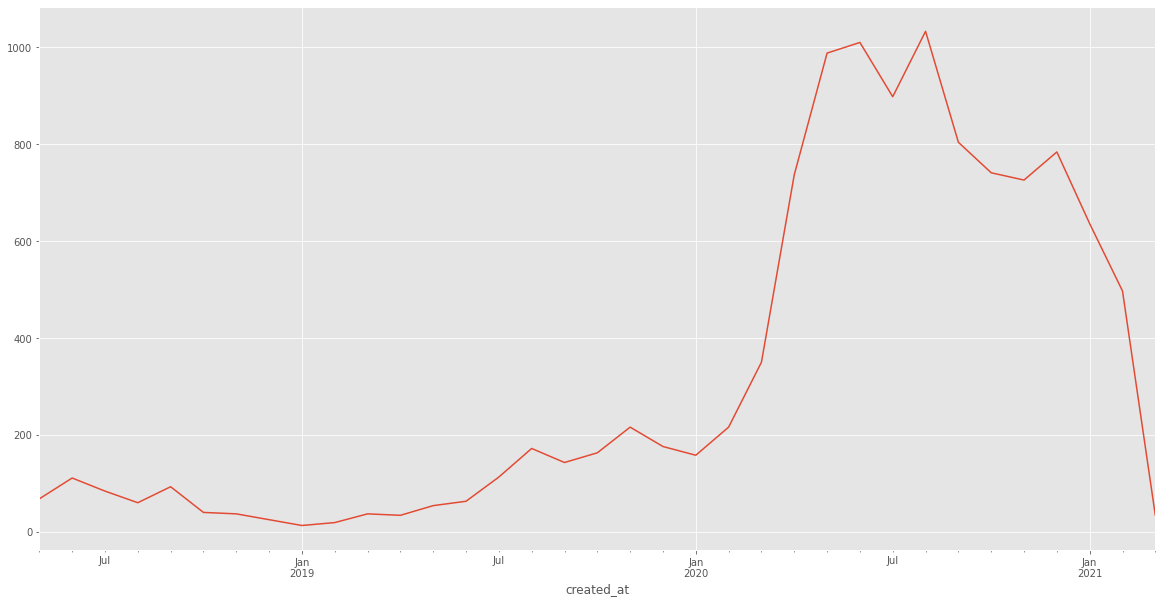

In [ ]:
df['created_at'] = pd.to_datetime(df['created_at'])
monthly_orders = df.groupby(df['created_at'].dt.to_period('M')).size()
monthly_orders.plot.line(figsize=(20,10))

In [ ]:
df['created_at'] = pd.to_datetime(df['created_at'])
monthly_sales = df.groupby(df['created_at'].dt.to_period('M'))['total_amount'].sum()
monthly_sales

/usr/local/lib/python3.7/dist-packages/pandas/core/arrays/datetimes.py:1092: UserWarning:

Converting to PeriodArray/Index representation will drop timezone information.



created_at
2018-05      5955457
2018-06      9142886
2018-07      7436054
2018-08      5422469
2018-09      9517454
2018-10      3943188
2018-11      4607564
2018-12      3222785
2019-01      1523953
2019-02      2052996
2019-03      4146046
2019-04      3446828
2019-05      4950451
2019-06      5726048
2019-07      9818599
2019-08     14274804
2019-09     12554537
2019-10     13050100
2019-11     17792100
2019-12     16522140
2020-01     12575170
2020-02     17611810
2020-03     36530730
2020-04     88770650
2020-05    127473780
2020-06    134098898
2020-07    108891589
2020-08    130317155
2020-09    103091508
2020-10     96428575
2020-11     91280722
2020-12    101662430
2021-01     82739399
2021-02     64744208
2021-03      3808704
Freq: M, Name: total_amount, dtype: int64

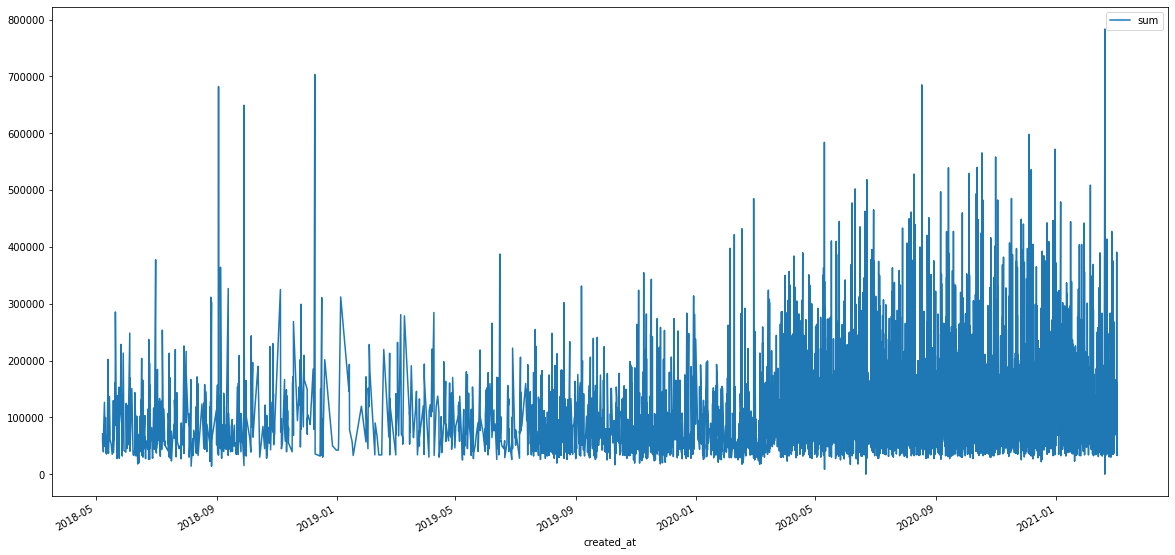

In [ ]:
df['created_at'] = pd.to_datetime(df['created_at'])
monthly_sales2 = df.groupby('created_at')['total_amount'].agg(['sum'])
monthly_sales2.plot.line(figsize=(20,10))

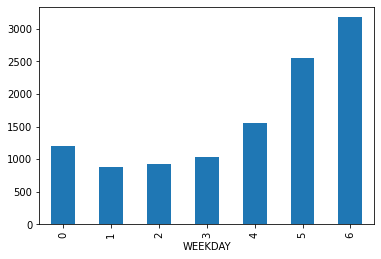

In [ ]:
df['WEEKDAY'] = df['created_at'].dt.weekday
weekday_orders = df.groupby('WEEKDAY').size()
weekday_orders.plot.bar()

# Serie de Tiempo

En esta sección se presenta la construccion de las series de tiempo a pronosticar, la base de datos y su posterior modelo.

In [ ]:
from statsmodels.tsa.base.datetools import dates_from_str
df.head(10)


,id,status,payment_choice,tax_amount,subtotal_amount,delivery_amount,total_amount,is_takeout,created_at,estimated_delivery_at,delivery_address,is_scheduled,people,payment_status,tip_amount,donation_amount,in_the_restaurant,birth_date,gender,WEEKDAY
0,5916,Por entregar,Efectivo o datáfono,20600,278100,15000,293100,False,2020-04-03 17:11:33.975146+00:00,2020-04-03 21:24:45.234106+00,Kra 19a No. 107-55,False,4,Pendiente,0,0,False,1984-04-03,Femenino,4
1,2375,Entregado,Efectivo o datáfono,3837,51800,5000,56800,False,2019-08-12 01:13:42.783548+00:00,2019-08-12 01:55:29.911761+00,Cll 87 No. 19c-41,False,2,Pendiente,0,0,False,1969-09-10,Femenino,0
2,6338,Por entregar,Efectivo o datáfono,14177,191400,10000,201400,False,2020-04-12 15:31:50.360010+00:00,2020-04-12 18:49:46.898467+00,Kra 16 No. 127B-43,False,4,Pendiente,0,0,False,1985-09-09,Femenino,6
3,5509,Por entregar,Tarjeta de crédito o débito,8488,57300,7500,64800,False,2020-03-14 23:21:25.825825+00:00,2020-03-15 00:14:11.968956+00,Kra 21 No. 103-51,False,1,Pagado,0,0,False,1992-07-18,Femenino,5
4,5108,Por entregar,Efectivo o datáfono,2948,39800,5000,44800,False,2020-02-23 20:01:41.371120+00:00,2020-02-24 01:56:08.05324+00,Kra 23 No. 118-44,False,1,Pagado,0,0,False,1993-03-05,Masculino,6
5,5089,Por entregar,Efectivo o datáfono,8851,119500,7500,127000,False,2020-02-23 16:42:12.048577+00:00,2020-02-23 19:31:07.48024+00,Kra 16 No. 102-16,False,2,Pagado,0,0,False,1984-07-01,Masculino,6
6,7182,Por entregar,Efectivo o datáfono,2429,32800,5000,37800,False,2020-05-02 22:30:20.785490+00:00,2020-05-02 23:03:42.532178+00,Cll 83 No. 5-57,False,1,Pendiente,0,0,False,1984-03-16,Femenino,5
7,11852,Por entregar,Efectivo o datáfono,0,84700,5000,98170,False,2020-07-28 00:34:00.863871+00:00,2020-07-28 01:00:55.516025+00,Kra 21 No. 120-33,False,1,Pendiente,8470,0,False,2001-07-01,Femenino,1
8,2515,Entregado,Efectivo o datáfono,5466,73800,5000,78800,False,2019-08-23 16:20:43.057700+00:00,2019-08-23 17:40:39.484801+00,Trv 18 No. 96-41,False,1,Pendiente,0,0,False,1970-12-03,Femenino,4
9,5574,Por entregar,Efectivo o datáfono,7303,98600,7500,106100,False,2020-03-18 17:02:02.924714+00:00,2020-03-18 18:22:50.056224+00,Kra 11A No. 116-40,False,2,Pendiente,0,0,False,1982-09-30,Masculino,2


In [ ]:
# base=pd.to_datetime(monthly_orders,monthly_sales)
type(monthly_orders)
monthly_orders=monthly_orders[0:34]
type(monthly_sales)
monthly_sales=monthly_sales[0:34]
print(monthly_orders.head(5))
print(monthly_sales.head(5))
print(monthly_orders.tail(5))
print(monthly_sales.tail(5))

created_at
2018-05     68
2018-06    111
2018-07     84
2018-08     60
2018-09     93
Freq: M, dtype: int64
created_at
2018-05    5955457
2018-06    9142886
2018-07    7436054
2018-08    5422469
2018-09    9517454
Freq: M, Name: total_amount, dtype: int64
created_at
2020-10    741
2020-11    726
2020-12    784
2021-01    636
2021-02    497
Freq: M, dtype: int64
created_at
2020-10     96428575
2020-11     91280722
2020-12    101662430
2021-01     82739399
2021-02     64744208
Freq: M, Name: total_amount, dtype: int64


## Pruebas de las series de tiempo

In [ ]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(monthly_orders.values)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

result = adfuller(monthly_sales.values)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.348821
p-value: 0.606551
Critical Values:
	1%: -3.654
	5%: -2.957
	10%: -2.618
ADF Statistic: -1.356726
p-value: 0.602838
Critical Values:
	1%: -3.654
	5%: -2.957
	10%: -2.618


Por lo tanto las series no son estacionarias y se deben transformar las series

In [ ]:
df[0:5]
base=df[['created_at','total_amount']]
type(base)
base['created_at'] = pd.to_datetime(base['created_at'],format="%d-%m/%Y")
base.head(5)
df2 = pd.concat([monthly_orders,monthly_sales], axis=1)
df2.columns = ['Cantidad_ventas', 'Ventas']
print(df2.head(5))
print(df2.tail(5))
#data = np.log(df2).diff().dropna()
datacv=np.log(df2).diff(2).dropna()
data = df2.diff().dropna()
print(data.head(5))
print(data.tail(5))

            Cantidad_ventas   Ventas
created_at                          
2018-05                  68  5955457
2018-06                 111  9142886
2018-07                  84  7436054
2018-08                  60  5422469
2018-09                  93  9517454
            Cantidad_ventas     Ventas
created_at                            
2020-10                 741   96428575
2020-11                 726   91280722
2020-12                 784  101662430
2021-01                 636   82739399
2021-02                 497   64744208
            Cantidad_ventas     Ventas
created_at                            
2018-06                43.0  3187429.0
2018-07               -27.0 -1706832.0
2018-08               -24.0 -2013585.0
2018-09                33.0  4094985.0
2018-10               -53.0 -5574266.0
            Cantidad_ventas      Ventas
created_at                             
2020-10               -63.0  -6662933.0
2020-11               -15.0  -5147853.0
2020-12                58.0  103817

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(datacv["Cantidad_ventas"].values)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))
from statsmodels.tsa.stattools import adfuller
result = adfuller(data["Cantidad_ventas"].values)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))
from statsmodels.tsa.stattools import adfuller
result = adfuller(data["Ventas"].values)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.543844
p-value: 0.511722
Critical Values:
	1%: -3.738
	5%: -2.992
	10%: -2.636
ADF Statistic: -3.603471
p-value: 0.005695
Critical Values:
	1%: -3.654
	5%: -2.957
	10%: -2.618
ADF Statistic: -3.834772
p-value: 0.002571
Critical Values:
	1%: -3.654
	5%: -2.957
	10%: -2.618


Se construye la nueva base con las variables seleccionadas

In [ ]:
#data2 = pd.concat([monthly_orders,data["Ventas"]], axis=1).dropna()
data2 = data
data2.columns = ['Cantidad_ventas', 'Ventas']
print(data2.head(5))
print(data2.tail(5))

            Cantidad_ventas     Ventas
created_at                            
2018-06                43.0  3187429.0
2018-07               -27.0 -1706832.0
2018-08               -24.0 -2013585.0
2018-09                33.0  4094985.0
2018-10               -53.0 -5574266.0
            Cantidad_ventas      Ventas
created_at                             
2020-10               -63.0  -6662933.0
2020-11               -15.0  -5147853.0
2020-12                58.0  10381708.0
2021-01              -148.0 -18923031.0
2021-02              -139.0 -17995191.0


Se observa un dato atipico en Marzo por lo tanto se tiene en cuenta

In [ ]:
print(len(data2))
#data2=data2[0:33]
print(data2.head(5))
print(data2.tail(5))

33
            Cantidad_ventas     Ventas
created_at                            
2018-06                43.0  3187429.0
2018-07               -27.0 -1706832.0
2018-08               -24.0 -2013585.0
2018-09                33.0  4094985.0
2018-10               -53.0 -5574266.0
            Cantidad_ventas      Ventas
created_at                             
2020-10               -63.0  -6662933.0
2020-11               -15.0  -5147853.0
2020-12                58.0  10381708.0
2021-01              -148.0 -18923031.0
2021-02              -139.0 -17995191.0


In [ ]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(data2["Cantidad_ventas"].values)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))
from statsmodels.tsa.stattools import adfuller
result = adfuller(data2["Ventas"].values)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.603471
p-value: 0.005695
Critical Values:
	1%: -3.654
	5%: -2.957
	10%: -2.618
ADF Statistic: -3.834772
p-value: 0.002571
Critical Values:
	1%: -3.654
	5%: -2.957
	10%: -2.618


Ya se tiene unas series que no dependen del tiempo y por lo tanto podemos el modelo propuesto para el proyecto

# Modelo 1 VAR 

Para este proyecto se propone un modelo VAR, dado el alto grado  de dependencia entre las variables Cantidad_ventas y Ventas





In [ ]:
import numpy as np
import matplotlib
from statsmodels.tsa.api import VAR, DynamicVAR
from statsmodels.tsa.base.datetools import dates_from_str
plt.style.use('ggplot')
model = VAR(data2)
results = model.fit(2)
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 30, Apr, 2021
Time:                     03:13:54
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    39.5426
Nobs:                     31.0000    HQIC:                   39.2308
Log likelihood:          -683.714    FPE:                9.43412e+16
AIC:                      39.0800    Det(Omega_mle):     6.99552e+16
--------------------------------------------------------------------
Results for equation Cantidad_ventas
                        coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------
const                      5.655638        17.972925            0.315           0.753
L1.Cantidad_ventas         2.460947         0.894808            2.750           0.006
L1.Ventas                 -0.0

AxesSubplot(0.125,0.125;0.775x0.755)
            Cantidad_ventas     Ventas
created_at                            
2018-06                43.0  3187429.0
2018-07               -27.0 -1706832.0
2018-08               -24.0 -2013585.0
2018-09                33.0  4094985.0
2018-10               -53.0 -5574266.0
            Cantidad_ventas      Ventas
created_at                             
2020-10               -63.0  -6662933.0
2020-11               -15.0  -5147853.0
2020-12                58.0  10381708.0
2021-01              -148.0 -18923031.0
2021-02              -139.0 -17995191.0


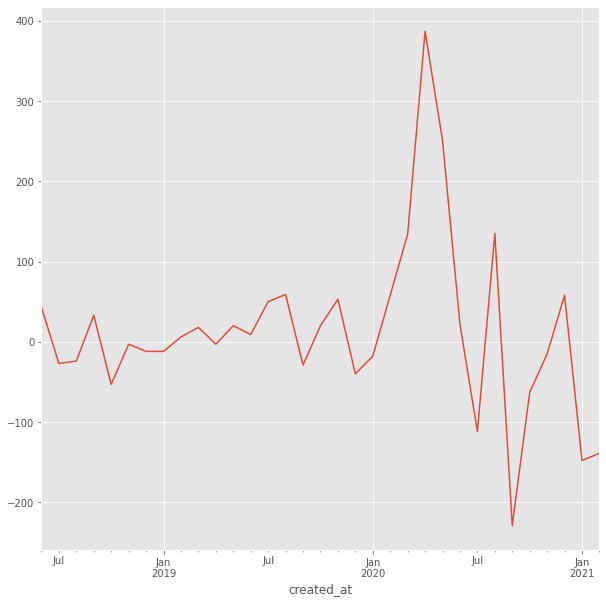

In [ ]:
print(data2["Cantidad_ventas"].plot.line(figsize=(10,10)))
print(data2.head(5))
print(data2.tail(5))

AxesSubplot(0.125,0.125;0.775x0.755)


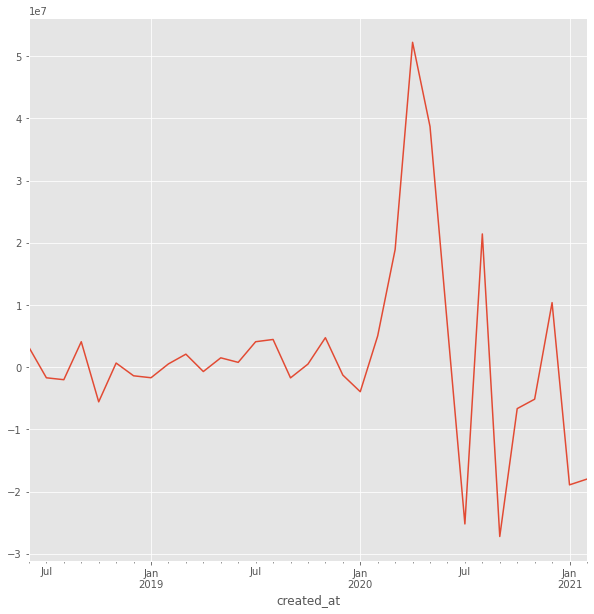

In [ ]:
print(data2["Ventas"].plot.line(figsize=(10,10)))

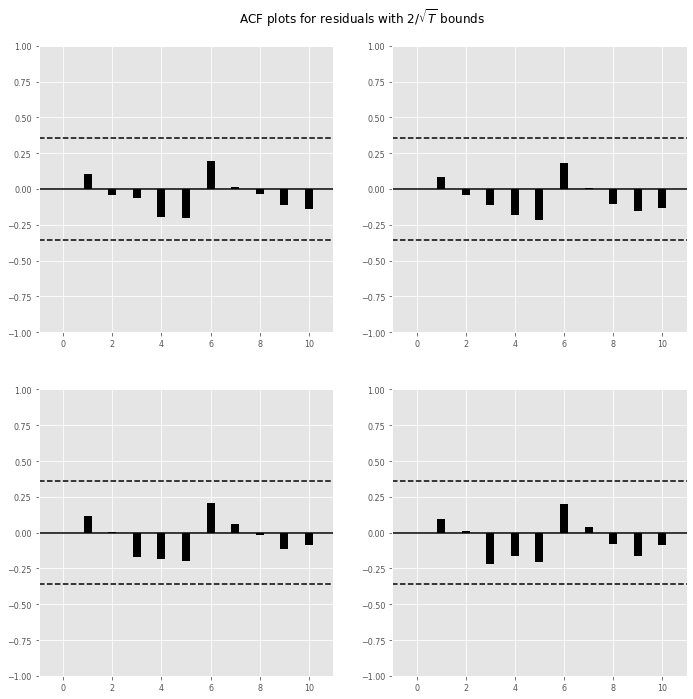

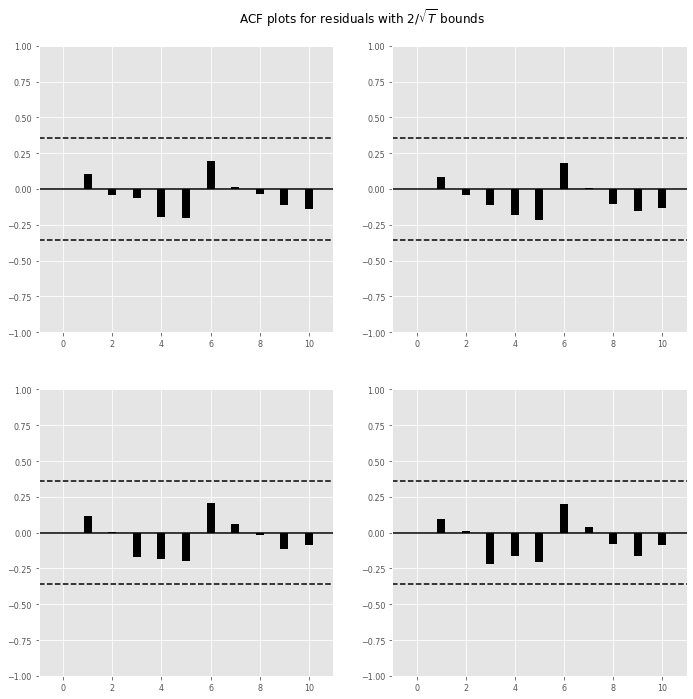

In [ ]:
results.plot_acorr()

In [ ]:
results = model.fit(maxlags=6, ic='aic')
lag_order = results.k_ar
results.forecast(data.values[-lag_order:], 5)


array([[-2.35682232e+02, -4.09213596e+07],
       [ 1.07684520e+02,  1.26390358e+07],
       [ 5.31912588e+01,  9.87260117e+06],
       [ 7.13522300e+01,  1.14447702e+07],
       [ 5.11213057e+01, -6.70941566e+05]])

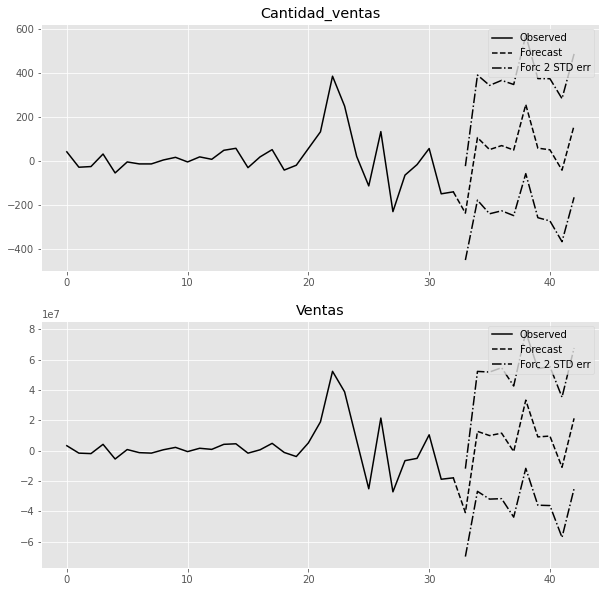

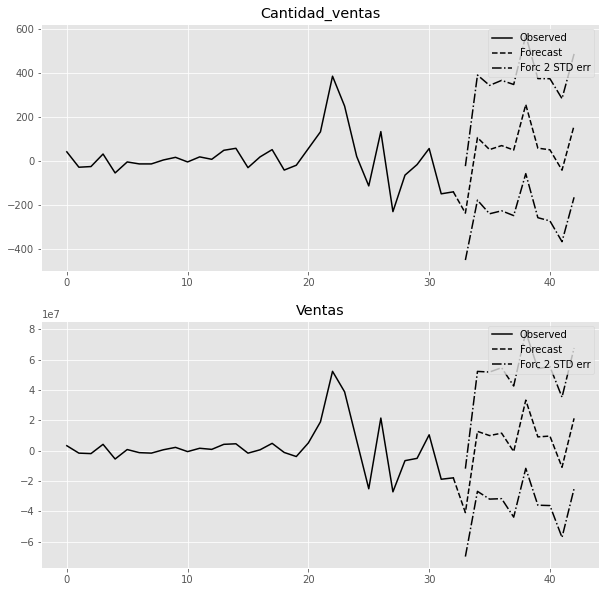

In [ ]:
results.plot_forecast(10)

# Modelo 2 Prophet


Se toman nuevamente los datos

In [ ]:
monthly_orders=monthly_orders[0:34]
monthly_sales=monthly_sales[0:34]
df2 = pd.concat([monthly_orders,monthly_sales], axis=1)
df2.columns = ['Cantidad_ventas', 'Ventas']
print(df2.head(5))
print(df2.tail(5))

            Cantidad_ventas   Ventas
created_at                          
2018-05                  68  5955457
2018-06                 111  9142886
2018-07                  84  7436054
2018-08                  60  5422469
2018-09                  93  9517454
            Cantidad_ventas     Ventas
created_at                            
2020-10                 741   96428575
2020-11                 726   91280722
2020-12                 784  101662430
2021-01                 636   82739399
2021-02                 497   64744208


Daremos un vistazo a las series de tiempo

34


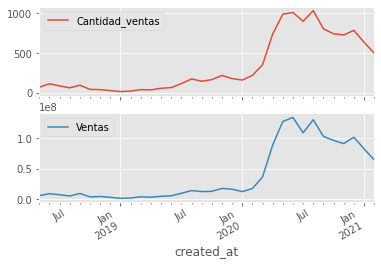

In [ ]:
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
plt.style.use('ggplot')
df2.plot(subplots=True)
print(len(df2))

## Modelo




In [ ]:
# make an in-sample forecast
from pandas import read_csv 
from pandas import to_datetime 
from pandas import DataFrame
from fbprophet import Prophet
from matplotlib import pyplot
# preparando los datos
df = read_csv('data.csv')
df.shape
df=df[["created_at","total_amount"]]
df.columns=["ds","y"]
df['ds'] = to_datetime(df['ds'])
monthly_sales = df.groupby(df['ds'].dt.to_period('M'))['y'].sum()
monthly_sales.head(5)
df=DataFrame(monthly_sales[0:34])
df.columns = ['y']
print(df.head())
print(df.tail())
df.dtypes
# define the model
model = Prophet()
# fit the model
#model.fit(df)
# define the period for which we want a prediction
#future = list()
#for i in range(1, 13):
#	date = '1968-%02d' % i
#	future.append([date])
#future = DataFrame(future)
#future.columns = ['ds']
#future['ds']= to_datetime(future['ds'])
# use the model to make a forecast
#forecast = model.predict(future)
# summarize the forecast
#print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())
# plot forecast
#model.plot(forecast)
#pyplot.show()

               y
ds              
2018-05  5955457
2018-06  9142886
2018-07  7436054
2018-08  5422469
2018-09  9517454
                 y
ds                
2020-10   96428575
2020-11   91280722
2020-12  101662430
2021-01   82739399
2021-02   64744208


/usr/local/lib/python3.7/dist-packages/pandas/core/arrays/datetimes.py:1092: UserWarning:

Converting to PeriodArray/Index representation will drop timezone information.

